# 构建目标检测主干框架代码


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feature_inputs (InputLayer)     [(None, 10, 4356)]   0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 10, 660)      2875620     Feature_inputs[0][0]             
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 10, 16)       10576       dense_62[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 10, 16)       31696       dense_62[0][0]                   
___________________________________________________________________________________________

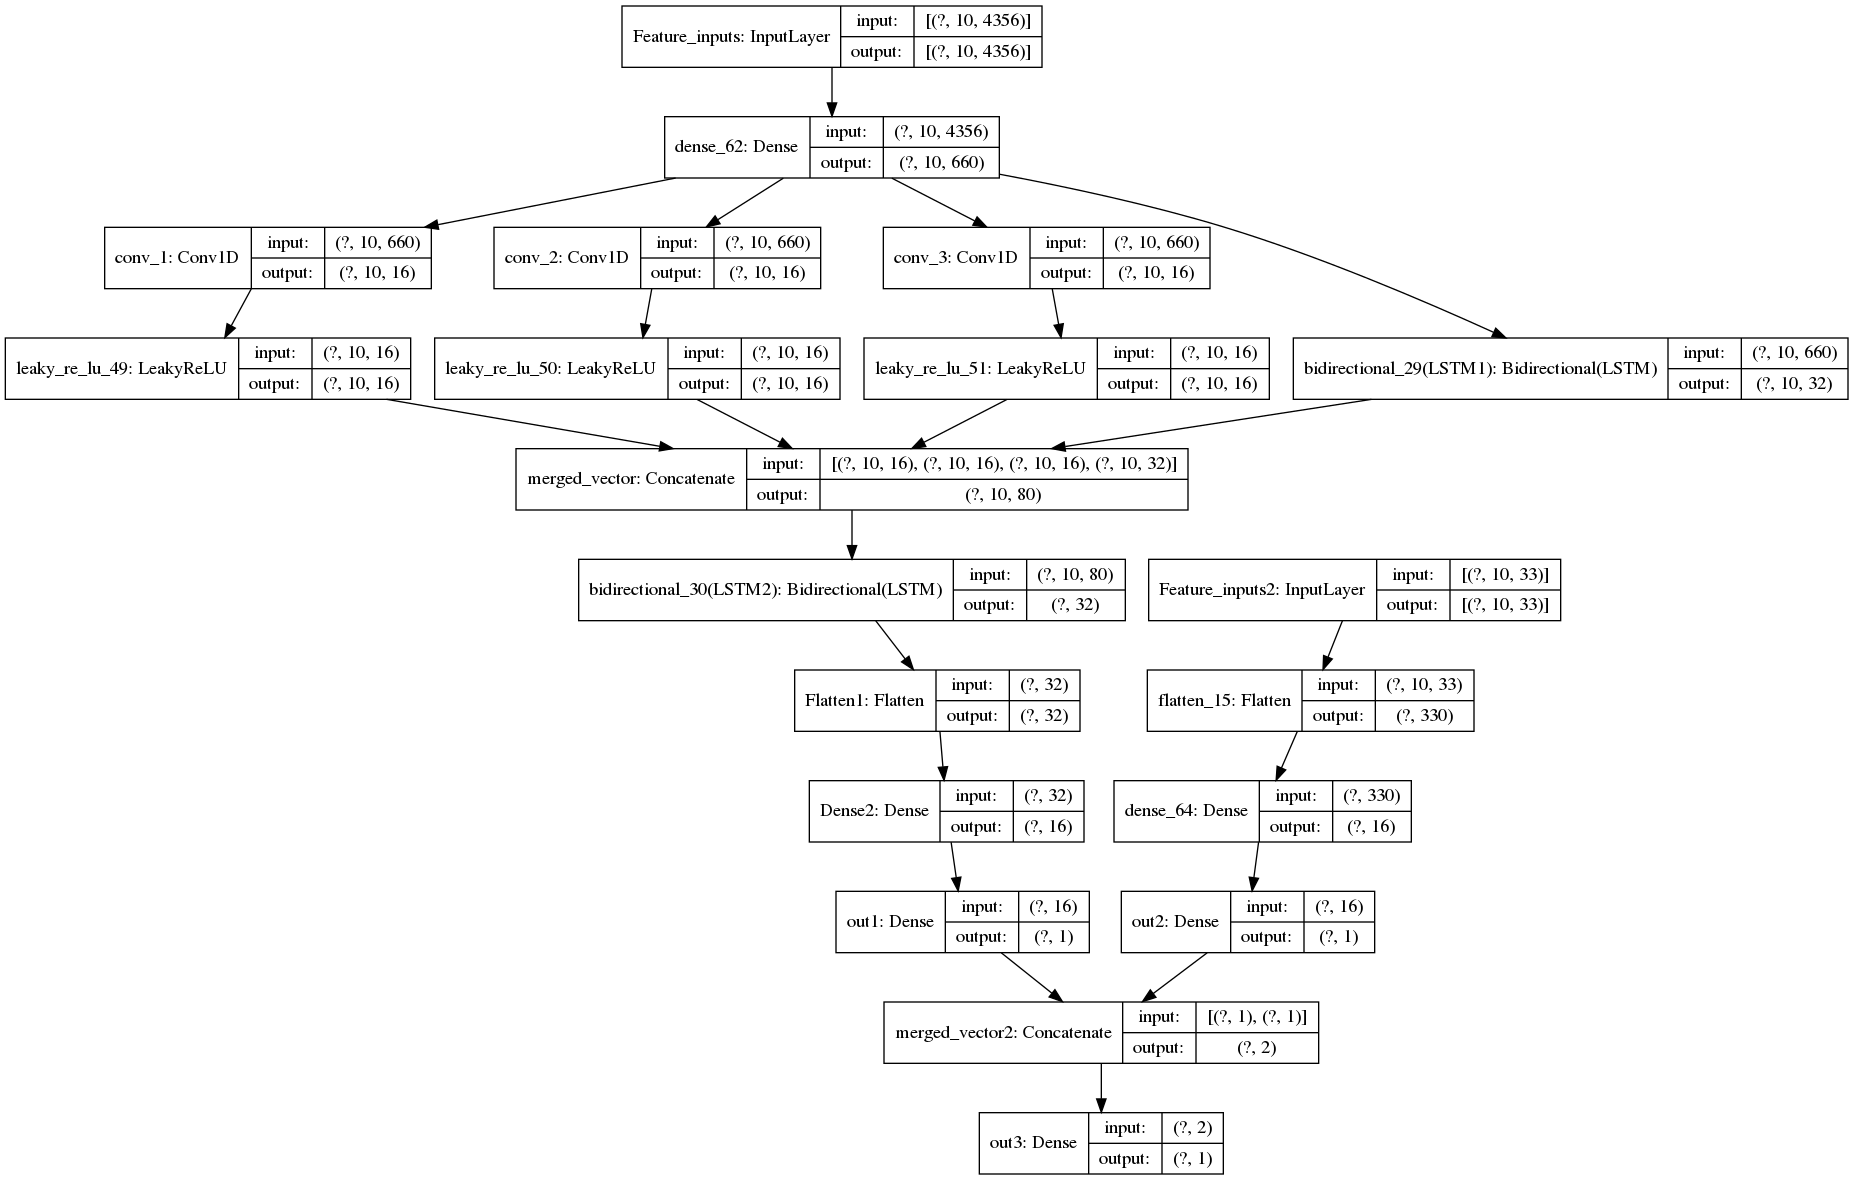

In [44]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf
# from spektral.layers import GraphConv
from tensorflow.keras.models import Model # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers


def build_model(input_seq_len=132, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam'
               ):
        
    # inputs
    Feature_inputs = L.Input(shape=(input_seq_len, 4356), name="Feature_inputs")
    Feature_inputs2 = L.Input(shape=(input_seq_len, 33), name="Feature_inputs2")

    Feature_inputs_new = L.Dense(660)(Feature_inputs)
    Feature_inputs_new2 = L.Dense(64)(Feature_inputs2)

    conv_1 = L.Conv1D(
        16, 1,
        padding='same',name="conv_1")(Feature_inputs_new)
    conv_1_1 = L.LeakyReLU()(conv_1)

    conv_2 = L.Conv1D(
        16,3,
        padding='same',name="conv_2")(Feature_inputs_new)
    conv_2_2 = L.LeakyReLU()(conv_2)

    
    conv_3 = L.Conv1D(
        16,4,
        padding='same',name="conv_3")(Feature_inputs_new)
    conv_3_3 = L.LeakyReLU()(conv_3)



    LSTM1 = L.Bidirectional(LSTM(16,input_shape=(input_seq_len,660),return_sequences=True,name='LSTM1'))(Feature_inputs_new)
    
    merged_vector = concatenate([conv_1_1, conv_2_2, conv_3_3, LSTM1], axis=-1,name="merged_vector")
    LSTM2 = L.Bidirectional(LSTM(16,name='LSTM2'))(merged_vector)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten1)
    out1 = Dense(1, activation='sigmoid',name="out1")(Dense2)
    
    Flatten2 = Flatten()(Feature_inputs2)
    Dense2 = Dense(16)(Flatten2)
    out2 = Dense(1,name='out2')(Dense2)
    
    merged_vector2 = concatenate([out1, out2], axis=-1,name="merged_vector2")
    out3 = Dense(1, activation='sigmoid',name="out3")(merged_vector2)
    
    model = Model(
        inputs=[
            Feature_inputs,Feature_inputs2
        ],
        outputs=out3,
    )
    model.compile(loss=losss,
                  optimizer=optimizerr,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    return model

model = build_model(input_seq_len=10, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam')
tf.keras.utils.plot_model(model,to_file='1.png',show_shapes=True,show_layer_names=True)   

In [1]:

import numpy as np
import random
import math
import os
import scipy.io
from scipy.io import loadmat
import scipy
from datetime import datetime
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import * 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))   #打印gpu信息
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"


1.15.0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [2]:
# data
# https://github.com/XiuzeZhou/NASA/blob/main/RNN%20%26%20LSTM.ipynb

# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)  # 加载mat文件
    filename = matfile.split("/")[-1].split(".")[0]  # 以‘.’和‘/’为分隔符分割，分割出路径中的文件名
            # nasa_count_data/B0006.mat  ---》  B0006
    col = data[filename]  # dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
    col = col[0][0][0][0]  # numpy   (1, 1 )  --->  (616,)  
    size = col.shape[0]

    data = []
    for i in range(size):
#         print(col.shape)
        k = list(col[i][3][0].dtype.fields.keys()) 
        # k:dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                        #'Current_charge', 'Voltage_charge', 'Time'])
        # “电压测量”、“电流测量”、“温度测量”、“电流充电”、“电压充电”、“时间”
        # col[i][0][0]  : 表示当前样本i的作业类别，放电、充电、阻抗
        # col[i][1][0]  : 表示当前样本i的作业温度
        # col[i][2][0]  : 表示当前样本i的作业日期，时间，'2008-04-02 13:08:17'
        # col[i][3][0]  : 表示当前样本i的作业六个参数值
        
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance': # 判断作业类型,非阻抗作业
            for j in range(len(k)):          # 遍历六个特征列
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l                 # 将读取到的数据放入对应的字典keys下
        d1['type'], d1['temp'] = str(col[i][0][0]), int(col[i][1][0])
        d1['time'], d1['data'] = str(convert_to_time(col[i][2][0])), d2
        data.append(d1)
    return data

# 提取锂电池容量
def getBatteryCapacity(Battery):
    # 电池容量在放电数据集 'discharge'的'Capacity'特征下；
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]  # 构成了(x, y)坐标系


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

# 检查样本列表中个样本的数据量
def samples_nums(Battery_list,dir_path,filetype='.mat'):
    for name in Battery_list:
        path = dir_path + name + filetype
        data = loadMat(path)
        python_y=np.array(data) #将matlab数据赋值给python变量
        c, d, im = 0, 0, 0
        for i in range(0,len(python_y)):
            if python_y[i]['type']=='charge': c+=1
            if python_y[i]['type']=='discharge': d+=1
            if python_y[i]['type']=='impedance': im+=1
        print('样本%s，总样本数：'%name,python_y.shape[0],
              '， 冲电记录次数：',c,'， 放电记录次数：',d,'， 阻抗记录次数：',im)

# 获取列表样本对应的电池数据     
def Battery_Data(Battery_list,dir_path):
    capacity, charge, discharge = {}, {}, {}
    for name in Battery_list:
        print('Load Dataset ' + name + '.mat ...')
        path = dir_path + name + '.mat'
        data = loadMat(path)
        print(len(data))
        capacity[name] = getBatteryCapacity(data)              # 放电时的容量数据
        charge[name] = getBatteryValues(data, 'charge')        # 充电数据
        discharge[name] = getBatteryValues(data, 'discharge')  # 放电数据
    return capacity, charge, discharge

# 作图，同样本数据对比图
def plot_Comparison(samples_name, data, list_name, color_list,x_ax=None,y_ax=None, unit=None, label=None):
    if samples_name!=None:
        # 单样本数据画图比对
        fig, ax = plt.subplots(1, figsize=(12, 8))
        c = 0
        for t,color in zip(list_name, color_list):
            Battery = data[samples_name][t]
            ax.plot(Battery[x_ax], Battery[y_ax], color, label='%s time: '%label+str(t))
            c += 1
        ax.set(xlabel=x_ax, ylabel=y_ax.split("_")[0] + ' (%s)'%unit, title='%s Curve'%label)
        plt.legend()

In [3]:
# 路径，样本列表
dir_path = "nasa_count_data/"
# Battery_list = ['B0005', 'B0006', 'B0007', 'B0018',
#                'B0025', 'B0026', 'B0027', 'B0028',
#                'B0029', 'B0030', 'B0031', 'B0032',
#                'B0033', 'B0034', 'B0036', 'B0038',
#                'B0039', 'B0040', 'B0041', 'B0042',
#                'B0043', 'B0044', 'B0045', 'B0046',
#                'B0047', 'B0048', 'B0049', 'B0050',
#                'B0051', 'B0052', 'B0053', 'B0054',
#                'B0055', 'B0056']
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']

# 检查数据个数，获取样本电池数据
samples_nums(Battery_list,dir_path,'.mat')     
capacity, charge, discharge = Battery_Data(Battery_list,dir_path)

样本B0005，总样本数： 616 ， 冲电记录次数： 170 ， 放电记录次数： 168 ， 阻抗记录次数： 278
样本B0006，总样本数： 616 ， 冲电记录次数： 170 ， 放电记录次数： 168 ， 阻抗记录次数： 278
样本B0007，总样本数： 616 ， 冲电记录次数： 170 ， 放电记录次数： 168 ， 阻抗记录次数： 278
样本B0018，总样本数： 319 ， 冲电记录次数： 134 ， 放电记录次数： 132 ， 阻抗记录次数： 53
Load Dataset B0005.mat ...
616
Load Dataset B0006.mat ...
616
Load Dataset B0007.mat ...
616
Load Dataset B0018.mat ...
319


In [4]:
print(len(discharge['B0005'][167]['Time']))

300


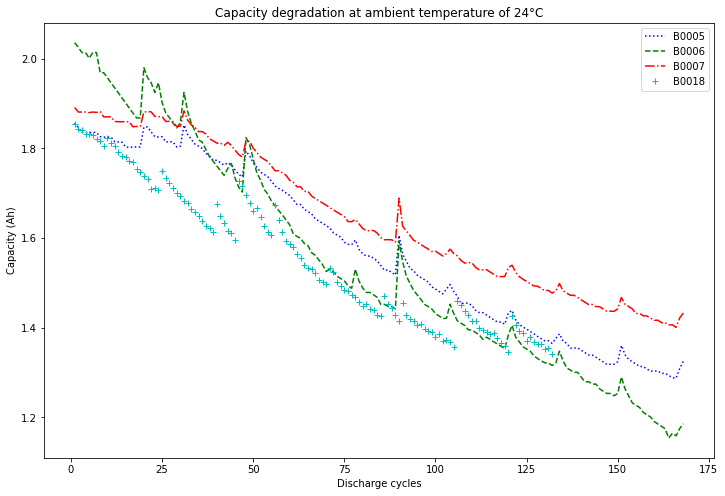

In [5]:
# 3. 容量 v.s. 充放电次数 曲线


fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c+']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = capacity[name]  # （循环次数， 当前容量）坐标
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

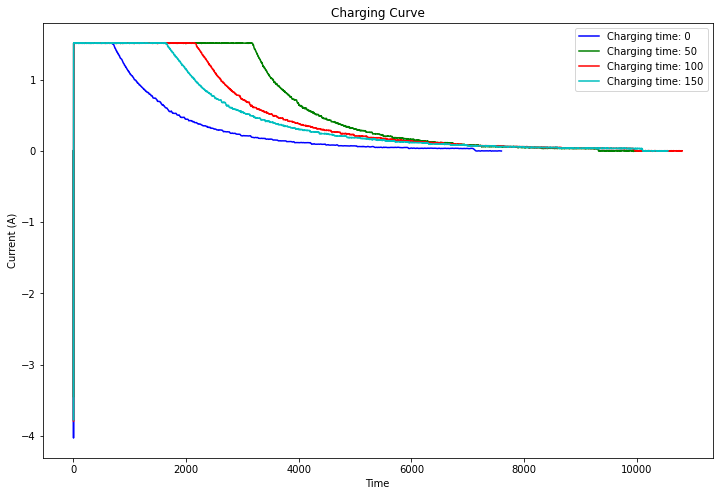

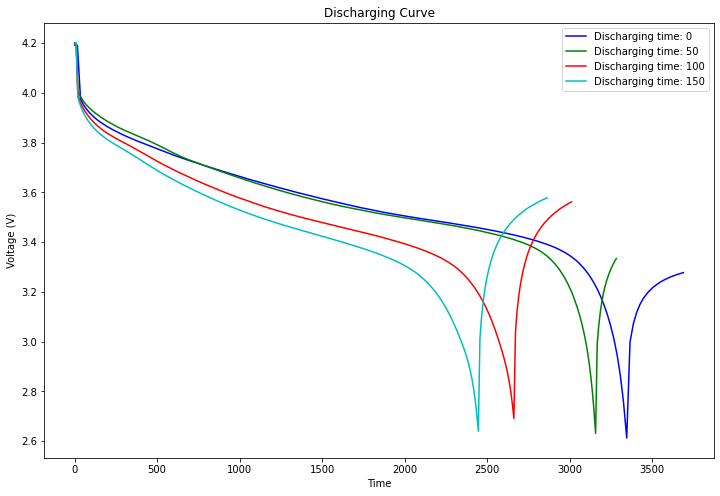

In [6]:
# 4. 充电电流 v.s. 充电时间 曲线
name = 'B0005'       #查看的电池号
time = [0, 50, 100, 150] #查看的充电次数
color_list = ['b', 'g', 'r', 'c']
plot_Comparison(samples_name=name, data=charge, 
                list_name=time, color_list=color_list, 
                x_ax='Time', y_ax='Current_measured', unit='A', label='Charging')
# 5. 放电电压 v.s. 充电时间 曲线
time_d = [0, 50, 100, 150]     #查看的放电次数
color_list_d = ['b', 'g', 'r', 'c']
plot_Comparison(samples_name=name, data=discharge, 
                list_name=time_d, color_list=color_list_d, 
                x_ax='Time', y_ax='Voltage_measured', unit='V',label='Discharging')

In [7]:
# 数据集打包模块
# 打包当前sheet序列数据和标签
# 重叠打包策略
def createXY(dataset,n_past):
    """
        dataset：传入数据集；
        n_past：lstm的timestep，预测下一个目标值时将在过去查看的步骤数；
        index: 预测目标标签；
        trainX — — →trainY
        eg：
            [0 : 30,0:5] → [30,0]
            [1:31, 0:5] → [31,0]
            [2:32,0:5] →[32,0]
    """
#     print(dataset.shape,dataset.shape[1])
    n_past=int(n_past)
#     index=int(index)
    dataX = [] # 所有的特征值
    dataY = [] # 目标预测标签

#     print(len(dataset),dataset[168])
    for i in range(n_past, len(dataset)):
#         print()
        if i<len(dataset):
            dataX.append(dataset[i - n_past:i])
            dataY.append(dataset[i])
        else:
            break
    return np.array(dataX),np.array(dataY)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(window_size,len(text)):  # 【window_size:-1】
        if i<len(text):
            sequence = text[i - window_size:i]      # 特征
            target = text[i]    # 标签,延后的序列。。。？？？

            x.append(sequence)
            y.append(target)
        else:
            break
        
    return np.array(x), np.array(y)

def get_train_test(data_dict, window_size=8, test_num=20):
    # 余下数据生成训练集
    x, y, x_test, y_test = [], [], [], []
    count = 0
    for k, v in data_dict.items():  # 返回可遍历的(键, 值) 元组数组，然后便利， k:样本名， v:样本对应数据（容量）
        data_x, data_y = build_sequences(text=v[1], window_size=window_size)
        data_x0, data_y0 = data_x[0:-test_num], data_y[0:-test_num]
        data_x1, data_y1 = data_x[-test_num:], data_y[-test_num:]
        if count==0:
            x, y = data_x0, data_y0
            x_test, y_test = data_x1, data_y1
        else:
            x, y = np.r_[x, data_x0], np.r_[y, data_y0]
            x_test, y_test = np.r_[x_test, data_x1], np.r_[y_test, data_y1]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
        count+=1
    return x, y, x_test, y_test

def shuffle_data(X,y):
    # shuffle数据集
    # X,y: 数据集样本和标签
    # return：shuffle后的特征和标签，以及打乱后的索引
    data_list=np.array(X)           # list of images
    label_list=np.array(y)           # list of labels

    ##如果image_list存的是读取的特征数据，而不是图片路径，不要注释后面两句（list无法索引内部list）
    #[list indices must be integers or slices, not list]
    #image_list = np.array(image_list)
    #label_list = np.array(label_list)

    index = [i for i in range(len(data_list))]
    np.random.shuffle(index)
    data = data_list[index]
    labels = label_list[index]
    return data, labels, index

# 获取所有样本列元素极值，用于归一化尺度
# def sheet_extreme(data,sheet_nums,category='regression'):
    
    
# 多维根据normalize归一化Positive / 反归一化negative
def NormalizeMult_1(data,normalize, type='Positive'):
    # 数据， 极值列表
    data = np.array(data)
    listlow = normalize[0][0]
    listhigh = normalize[0][1]
    delta = listhigh - listlow
    for i in range(0,data.shape[0]):
        if delta != 0:
            if type=='Positive':
                    data[i]  =  (data[i] - listlow)/delta                  
            elif type=='Negative':
                    data[i]  =  data[i]*delta + listlow
                    
    
    
    
#     for i in range(0,data.shape[1]):
#         listlow = normalize[i,0]
#         listhigh = normalize[i,1]
#         delta = listhigh - listlow
#         if delta != 0:
#             for j in range(0,data.shape[0]):
#                 if type=='Positive':
#                     data[j,i]  =  (data[j,i] - listlow)/delta                  
#                 elif type=='Negative':
#                     data[j,i]  =  data[j,i]*delta + listlow
    return  data


# 获取所有样本列元素极值，用于归一化尺度
def sheet_extreme(data,category='1'):
    
    # 声明一个初始化极值标签列表，取自样本
    if  category=='4':
        normalize_end = np.array( [[4.5358, 9.3226],
                                 [0.0000, 1.6654],
                                 [4.8653, 1.0000],
                                 [0.0000, 1.0000]])
    elif category=='3':
        normalize_end = np.array( [[4.5358, 9.3226],
                                  [0.0000, 1.6654],
                                  [0.0000, 1.6654]])         
    elif category=='2':
        normalize_end = np.array( [[4.5358, 9.3226],
                                 [0.0000, 1.6654]])  
    elif category=='1':
        normalize_end = np.array( [[4.5358, 9.3226]])  
        
    for i in range(0,data.shape[1]): # 遍历列
        #第i列数据
        listt = data[:,i]
        # 获得目标列极值
        listlow,listhigh =  np.percentile(listt, [0, 100])
        # 存储目标列极值
        normalize_end[i,0] = listlow
        normalize_end[i,1] = listhigh
    print('end_normalize:\n',normalize_end)
    return normalize_end
        
from functools import partial
def flatten(x):
    # 上面这个 flatten 函数有两个返回值，一个是拉平后的 1 维数组，第二个是恢复原来形状的函数
    # a2,unflatten = flatten(a1), unflatten(a2) = a1
    original_shape = x.shape
    return x.flatten(), partial(np.reshape, newshape=original_shape)


from sklearn.preprocessing import MinMaxScaler
# 数据归一化
def Fit_transform(raw_data,a,b):
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(a, b))
    return scaler.fit_transform(raw_data), scaler
def Inverse_transform(raw_data,scaler):
    # 将标准化后的数据转换为原始数据（反归一化）
    return scaler.inverse_transform(raw_data)  



In [8]:
# CNN1D模型三特征
def build_model_cnn1d():
    
    # 定义输入
#     input_data_sm = Input(shape=(1,1), name='input_data_sm')
#     input_data_wh = Input(shape=(140,1), name='input_data_wh')
    input_data_full = Input(shape=(16,1), name='input_data_full')

    # WH处理分支
    cnn_out = Conv1D(filters=64, kernel_size=8, 
                     activation='relu',padding='same', input_shape=(16,1),name="cnn_out")(input_data_full)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(50, activation='sigmoid',name="Dense2")(Flatten2)
#     predictions = Dense(1, activation='sigmoid',name="predictions")(merged_vector)
    # 再在上面添加一个逻辑回归层
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)


    inputs = [input_data_full]
    # 定义一个连接推特输入和预测的可训练的模型
    model = Model(inputs, predictions1)  ####
#     model = Model(inputs, [predictions0,predictions1,predictions2])  ####

    model.compile(optimizer='adam',  #optimizers.Adam(lr=0.001,decay=0.004),
                  loss='mse',
                  metrics=['accuracy'])
    model.summary()
    x = 'CNN1D'
    return model,x

# LSTM
def build_model_LSTM():
    input_data_full = Input(shape=(16,1), name='input_data_full')
    LSTM1 = LSTM(64,input_shape=(16,1),return_sequences=True,name='LSTM1')(input_data_full)
    LSTM2 = LSTM(64,name='LSTM2')(LSTM1)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer='adam',
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'LSTM2'
    return model,x
def build_model_LSTM1():
    input_data_full = Input(shape=(16,1), name='input_data_full')
    LSTM1 = LSTM(64,input_shape=(16,1),return_sequences=True,name='LSTM1')(input_data_full)
    Flatten1 = Flatten(name="Flatten1")(LSTM1)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer='adam',
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'LSTM1'
    return model,x

# GRU
def build_model_GRU():
    input_data_full = Input(shape=(16,1), name='input_data_full')
    GRU1 = GRU(16,input_shape=(16,1),return_sequences=True,name='GRU1')(input_data_full)
    GRU2 = GRU(16,return_sequences=True,name='GRU2')(GRU1)
    GRU3 = GRU(16,name='GRU3')(GRU2)
    Flatten1 = Flatten(name="Flatten1")(GRU3)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer='adam',
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'GRU3'
    return model,x

(492, 16, 1) (492, 1) (80, 16, 1) (80, 1)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data_full (InputLayer) [(None, 16, 1)]           0         
_________________________________________________________________
LSTM1 (LSTM)                 (None, 16, 64)            16896     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 64)                33024     
_________________________________________________________________
Flatten1 (Flatten)           (None, 64)                0         
_________________________________________________________________
predictions1 (Dense)         (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train on 492 samples, validate on 80 samples
Epoch 1/30
488/492 [==============

488/492 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.0041
Epoch 00026: loss improved from 0.00144 to 0.00133, saving model to ./test1/model_LSTM2_1.hdf5
492/492 [==============================] - 1s 1ms/sample - loss: 0.0013 - acc: 0.0041 - val_loss: 0.0032 - val_acc: 0.0250
Epoch 27/30
488/492 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.0041 
Epoch 00027: loss did not improve from 0.00133
492/492 [==============================] - 1s 1ms/sample - loss: 0.0014 - acc: 0.0041 - val_loss: 0.0036 - val_acc: 0.0250
Epoch 28/30
440/492 [=========================>....] - ETA: 0s - loss: 0.0014 - acc: 0.0045
Epoch 00028: loss did not improve from 0.00133
492/492 [==============================] - 1s 1ms/sample - loss: 0.0013 - acc: 0.0041 - val_loss: 0.0036 - val_acc: 0.0250
Epoch 29/30
488/492 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.0041 
Epoch 00029: loss improved from 0.00133 to 0.00131, saving model to ./test1/model_LS

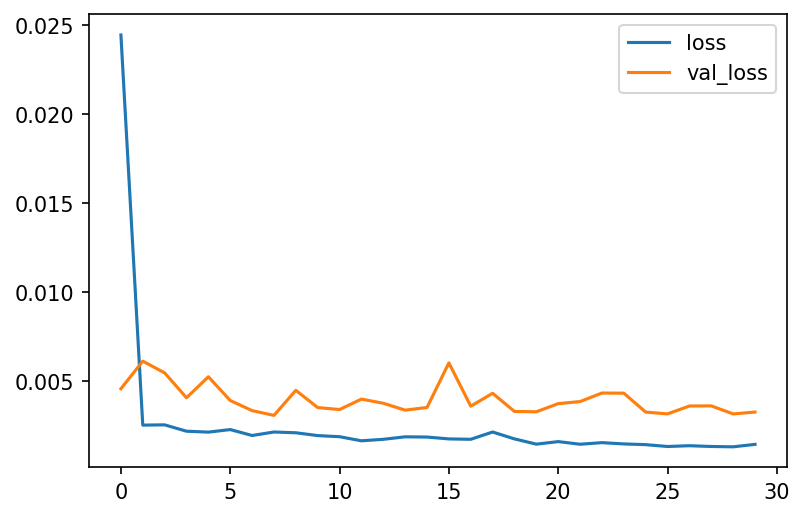

In [11]:
# keras-tf相关模块
import tensorflow as tf
from keras.models import load_model
from tensorflow.python.keras import backend as K  
from tensorflow.keras.models import * # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers
# from keras.layers import *
# 导入ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint,TensorBoard,Callback,ReduceLROnPlateau,EarlyStopping
# keras查看GPU模块
from keras.utils import *  # multi_gpu_model, plot_model
import time




# 单特征训练
def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, 
         weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0, list_nums=4):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】
    score_list, result_list = [], []
    # 训练数据准备
    train_x1, train_y1, test_x1, test_y1 = get_train_test(capacity, window_size=feature_size)
    
    # 归一化
    train_x1_, s1 = Fit_transform(train_x1,0,1)  # s1: <class 'sklearn.preprocessing._data.MinMaxScaler'>
    train_y1_, s2 = Fit_transform(train_y1.reshape(-1,1),0,1)
    test_x1_,  s3 = Fit_transform(test_x1,0,1)
    test_y1_,  s4 = Fit_transform(test_y1.reshape(-1,1),0,1)
    Extremum_matrix = [s1,s2,s3,s4]
    # 添加维度，编程网络输入三维
    train_x2, test_x2 = train_x1_.reshape(train_x1_.shape[0],feature_size,1), test_x1_.reshape(test_x1_.shape[0],feature_size,1)
    # shuffle 测试数据（样本后部分）
    train_x, train_y,_ = shuffle_data(train_x2, train_y1_)
    test_x, test_y,_ = shuffle_data(test_x2, test_y1_)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

#     # 模型配置
    model,strr = build_model_LSTM() 

    
    checkpoint_save_dir='./test1/'
    EarlyStop=EarlyStopping(monitor='loss'  #'val_acc',
                            ,patience=30,verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_%s_1.hdf5"%strr),
                                 monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, EarlyStop]

    start_sampling = time.time()
    # hist_sampling = model.fit(X_train,y_train,
    hist_sampling = model.fit(train_x, train_y,
    #                           validation_split = 0.2, 
                              validation_data=(test_x, test_y),
                              batch_size=8, epochs=30, 
                              callbacks=callbacks_list,#,reduce_lr],
                              shuffle=True,
                              verbose=1)
    end_sampling = time.time()
    print('训练结束！！')
    print('训练时间（分钟）：',(end_sampling-start_sampling)/60)

    score_sampling = model.evaluate(test_x, test_y, batch_size=8)
    # score_sampling = model.evaluate(X_test,y_test, batch_size=128)
    print(score_sampling)
    plt.figure(dpi=150)
    plt.plot(hist_sampling.history['loss'], label='loss')
#     plt.plot(hist_sampling.history['acc'], label='acc')
#     plt.plot(hist_sampling.history['val_acc'], label='val_acc')
    plt.plot(hist_sampling.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
    return model, train_x, train_y, test_x, test_y, train_x1, train_y1, test_x1, test_y1, Extremum_matrix

# 0.004 0.018
        
model, train_x, train_y, test_x, test_y, train_x1, train_y1, test_x1, test_y1, Extremum_matrix = tain()
#         setup_seed(seed)
#         model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
#         model = model.to(device)

(80, 16)


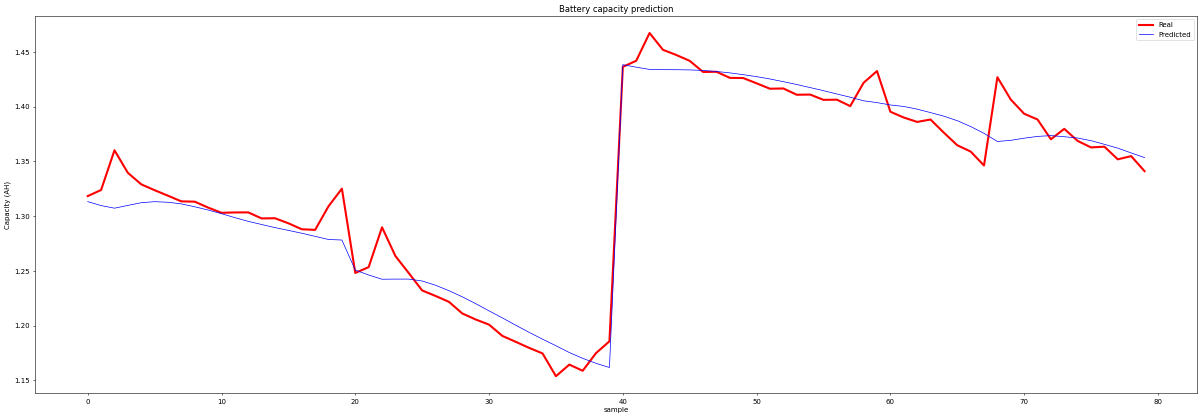

In [16]:
print(test_x1.shape)
test_x1_,  s5 = Fit_transform(test_x1,0,1)
test_y1_,  s6 = Fit_transform(test_y1.reshape(-1,1),0,1)

prediction=model.predict(test_x1_.reshape(80,16,1))

prediction_ = Inverse_transform(prediction, s6)

# 12V-7AH/20HR各代号的含义：
# 1、12V：电池的额定电压。
# 2、7AH：电池的容量，表示该电瓶以7A放电可工作一小时,若以1A放电可工作7小时。
# 3、20HR：建议电池的放电速率为20小时，HR是Hour Rate即倍率的缩写。（20HR）20小时放电率，该电池适于0.35A放电20小时。也就是说不宜大电流放电。

# print(prediction_.shape,test_y1.shape)
# 绘图展示
plt.figure(figsize = (30,10),dpi=50)
plt.plot(test_y1.reshape(-1,1), color = 'red', label = 'Real',linewidth=3)
plt.plot(prediction_, color = 'b', label = 'Predicted',linewidth=1)
plt.title('Battery capacity prediction')
plt.xlabel('sample')
plt.ylabel('Capacity (AH)')
plt.legend()
plt.show()

(492, 16)


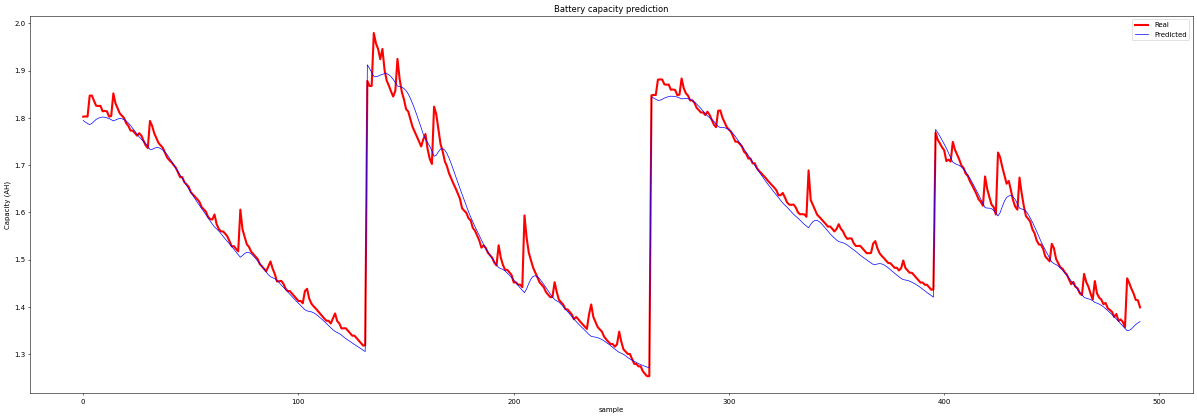

In [14]:
print(train_x1.shape)
train_x1_,  s7 = Fit_transform(train_x1,0,1)
train_y1_,  s8 = Fit_transform(train_y1.reshape(-1,1),0,1)

prediction2=model.predict(train_x1_.reshape(train_x1.shape[0],16,1))

prediction_2 = Inverse_transform(prediction2, s8)

# 12V-7AH/20HR各代号的含义：
# 1、12V：电池的额定电压。
# 2、7AH：电池的容量，表示该电瓶以7A放电可工作一小时,若以1A放电可工作7小时。
# 3、20HR：建议电池的放电速率为20小时，HR是Hour Rate即倍率的缩写。（20HR）20小时放电率，该电池适于0.35A放电20小时。也就是说不宜大电流放电。

# print(prediction_.shape,test_y1.shape)
# 绘图展示
plt.figure(figsize = (30,10),dpi=50)
plt.plot(train_y1.reshape(-1,1), color = 'red', label = 'Real',linewidth=3)
plt.plot(prediction_2, color = 'b', label = 'Predicted',linewidth=1)
plt.title('Battery capacity prediction')
plt.xlabel('sample')
plt.ylabel('Capacity (AH)')
plt.legend()
plt.show()

In [17]:
# sklearn科学计算模块
# keras-sklearn计算相关模块
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
# sklearn计算模块
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,classification_report,confusion_matrix
from sklearn.svm import SVC, SVR
# sklearn数据处理模块
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit,train_test_split,learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def eva_ind(data_gt,data_pre):
    
    gt = data_gt
    pre = data_pre
    pre_mean = np.mean(gt)

    # 获取绝对值误差
    Abs = []
    Abs_error = []
    for i in range(0,len(gt)):
    #     print(i)
        Abs.append(abs(pre[i]-gt[i])) # 绝对误差
        Abs_error.append(abs(gt[i]-pre_mean)) # 标签-预测平均值

    mse = mean_squared_error(pre, gt) # 均方误差
    rmse = np.sqrt(mean_squared_error(pre, gt)) # 根均方误差
    r2_s = r2_score(gt, pre) # 决定系数，反映因变量的全部变异能通过回归关系被自变量解释的比例

    # 平均偏差
    pre_mean_error = np.mean(Abs_error)
    # print(pre_mean_error)
    # 平均误差除以预测集平均值
    relative_error =  pre_mean_error/ pre_mean   

    # 平均绝对值误差（mean_absolute_error）
    mae =  mean_absolute_error(gt,pre)
        # 真实值与
    print(f"测试集均方误差(MSE)：{mse}")
    print(f"测试集根均方误差(RMSE)：{rmse}")
    print(f"测试集平均绝对误差：{mae}")
    print(f"测试集R^2：{r2_s}")
    print(f"测试集相对平均误差：{relative_error*100}%")
print('---')
eva_ind(test_y1,prediction_)
print('---')
eva_ind(train_y1,prediction_2)


---
测试集均方误差(MSE)：0.0003207033597570683
测试集根均方误差(RMSE)：0.017908192531829344
测试集平均绝对误差：0.013264216450853664
测试集R^2：0.9557968376820009
测试集相对平均误差：5.360328947805525%
---
测试集均方误差(MSE)：0.0007598136385409056
测试集根均方误差(RMSE)：0.027564717276636553
测试集平均绝对误差：0.017945379326110393
测试集R^2：0.972984619844387
测试集相对平均误差：9.055994015555727%


In [95]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):  # 【window_size:-1】
        sequence = text[i:i+window_size]      # 特征
        target = text[i+1:i+1+window_size]    # 标签,延后的序列。。。？？？

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    
    # 该部分是选取一个step_time序列为测试集
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]  # 且分出训练数据和测试数据
#     print(len(data_dict),len(data_sequence),len(train_data),len(test_data))
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)   # 制作数据集特征和标签
#     print(len(train_x[0]),len(train_y[0]))
    
    # 余下数据生成训练集
    for k, v in data_dict.items():  # 返回可遍历的(键, 值) 元组数组，然后便利
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
    return train_x, train_y, list(train_data), list(test_data)

# 相对误差
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    # 设置随机数种子，为所有的模式提供固定随机情况，使得实验课复现
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [62]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)
 
    def forward(self, x):           # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x) 
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)      # out shape: (batch_size, n_class=1)
        return out

In [194]:
from torchsummary import summary

def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, 
         weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】

    
    score_list, result_list = [], []
    for i in range(4):
        name = Battery_list[i]  # 样本列表
        # 划分数据集
        train_x, train_y, train_data, test_data = get_train_test(capacity, name, window_size=feature_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
#         net11 = model
#         summary(net11)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()  # 生成的测试集
        loss_list, y_ = [0], []     # 声明loss和pre容器
        mae, rmse, re = 1, 1, 1     # 初始化评价指标
        score_, score = 1,1         # 初始化评价列表
        
        for epoch in range(EPOCH):
            # 数据处理
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)
            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            
            output= model(X)                   # 预测结果
            output = output.reshape(-1, 1)
            loss = criterion(output, y)        # 计算loss
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()    #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)                 # shape: (batch_size, 1, input_size)
                    
                    pred = model(x)
#                     print('???????????????????????/',pred.shape)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)                          #测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)                     #保存输出序列最后一个点的预测值
                y_.append(point_list)                                 #保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list,loss_list,model

In [195]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [196]:
window_size = 16     # step_time
EPOCH = 1000         
lr = 0.001           # learning rate
hidden_dim = 256     # 隐层维度，神经元个数
num_layers = 2       # 隐层层数
weight_decay = 0.0   # 学习率衰减
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0 # 额定容量
 
# 进行十次随机数固定实验，并输出loss\MAE\RMSE\RE
SCORE = []
RES = []
LOSS = []
seed = 0
# for seed in range(2):
#     print('seed: ', seed)
#     score_list, res, loss_list = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
#                          weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
#     print('------------------------------------------------------------------')
#     for s in score_list:  
#         SCORE.append(s)
# #     if seed == 2: LOSS.append(loss_list)
# # plt.plot(res, 'b', label='loss')


score_list, res, loss_list, model = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
print('------------------------------------------------------------------')
for s in score_list:  
    SCORE.append(s)

mlist = ['re', 'mae', 'rmse']
for i in range(3):
    s = [line[i] for line in SCORE] 
    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s)))) # 输出均值
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1099 | RMSE:0.1247 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.0914 | RMSE:0.1031 | RE:1.0000
epoch:299 | loss:0.0003 | MAE:0.0705 | RMSE:0.0830 | RE:0.0566
epoch:399 | loss:0.0002 | MAE:0.0563 | RMSE:0.0702 | RE:0.0755
4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0005 | MAE:0.1216 | RMSE:0.1448 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1183 | RMSE:0.1418 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1050 | RMSE:0.1253 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1055 | RMSE:0.1217 | RE:1.0000
epoch:499 | loss:0.0001 | MAE:0.1188 | RMSE:0.1325 | RE:0.5889
epoch:599 | loss:0.0001 | MAE:0.1353 | RMSE:0.1486 | RE:0.6000
4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1338 | RMSE:0.1542 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1168 | RMSE:0.1289 | RE:0.1258
epoch:299 | loss:0.0003 | MAE:0.1216 | RMSE:0.1247 | RE:0.3444
4 132 17 115
16 16
sample size: 457
epoch:99 | loss:0.0007 | MAE:0.0566 | RM